<a href="https://colab.research.google.com/github/eto-ai/rikai/notebooks/UncertaintySampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Sampling

[Active Learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)) is one such technique that helps ML practitioners intelligently select high-value raw data to be labeled to maximize model improvement. Studies have shown that this type of learning strategy can produce significant improvement in model accuracy for the same number of samples; or require significantly fewer examples to reach the same accuracy.


In [1]:
!python -V
!nvidia-smi
!java --version

Python 3.8.12
Sat Jan 29 00:58:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:07:00.0 Off |                  N/A |
| 41%   33C    P8     4W / 280W |    179MiB / 24186MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [2]:
#!pip install rikai[mlflow,pytorch]
!pip install -q --force -U git+https://github.com/eddyxu/rikai.git@lei/uncertainty_sampling#egg=rikai\&subdirectory=python
!pip install -q mlflow==1.22 torch torchvision

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.1 which is incompatible.
ipykernel 6.4.1 requires ipython<8.0,>=7.23.1, but you have ipython 8.0.1 which is incompatible.


In [3]:
import mlflow
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from rikai.spark.utils import get_default_jar_version

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

rikai_version = get_default_jar_version(use_snapshot=False)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
spark = (
    SparkSession
    .builder
    .config("spark.jars.packages", f"ai.eto:rikai_2.12:0.1.0")
    .config(
        "spark.sql.extensions",
        "ai.eto.rikai.sql.spark.RikaiSparkSessionExtensions",
    )
    .config(
        "spark.rikai.sql.ml.registry.mlflow.tracking_uri",
        MLFLOW_TRACKING_URI,
    )
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "1g")
    .master("local[2]")
    .getOrCreate()
);

22/01/29 00:59:03 WARN Utils: Your hostname, station resolves to a loopback address: 127.0.1.1; using 172.16.0.2 instead (on interface enp6s0)
22/01/29 00:59:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/lei/.ivy2/cache
The jars for the packages stored in: /home/lei/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-58016ebf-4d9a-4ed9-b964-76caf2709041;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/lei/miniconda3/envs/coco/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found ai.eto#rikai_2.12;0.1.0 in central
	found org.antlr#antlr4-runtime;4.8-1 in central
	found com.thoughtworks.enableIf#enableif_2.12;1.1.7 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found com.typesafe.scala-logging#scala-logging_2.12;3.9.4 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.circe#circe-generic_2.12;0.12.3 in central
	found com.chuusai#shapeless_2.12;2.3.3 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found io.circe#circe-parser_2.12;0.12.3 in central
	found io.circe#circe-jawn_2.12;0.12.3 in central
	found org.typelevel#jawn-parser_2.12;0.14.2 in central
	found org.mlflow#mlflow-client;1.21.0 in central
	found org.apache.logging.log4j#log4j-co

In [4]:
# From https://pytorch.org/vision/0.11/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

@udf
def coco_name(idx: int) -> str:
  return COCO_INSTANCE_CATEGORY_NAMES[idx]

spark.udf.register("coco_name", coco_name)

# Create a category table
spark.createDataFrame(
    [{"label": idx, "name": name} for idx, name in enumerate(COCO_INSTANCE_CATEGORY_NAMES)]
).createOrReplaceTempView("cats")

# Preparing data

We use Coco's evaluation dataset to prepare a [Rikai](https://github.com/eto-ai/rikai) dataset. 

Note that, we only use eval set because it can fit into Google Colab's disk quota. 


In [5]:
from pathlib import Path

coco_dir = Path("./coco")
if not coco_dir.exists() and True:
  !mkdir -p coco
  !wget http://images.cocodataset.org/zips/val2017.zip -O coco/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco/annotations.zip
  !cd coco && find . -name '*.zip' -exec unzip -qq {} \; && rm *.zip

from rikai.contrib.datasets.coco import convert_instance

!rm -rf spark-warehouse/
df = convert_instance(
    spark, 
    "coco/annotations/instances_val2017.json",
    "coco/val2017",
)
df.write.mode("overwrite").save("datasets/coco")
df.createOrReplaceTempView("coco")

# Lets also create a COCO-1000 dataset for faster demo purpose
df.limit(1000).createOrReplaceTempView("coco_1k")

22/01/29 00:59:09 WARN TaskSetManager: Stage 2 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


In [6]:
spark.sql("SHOW TABLES").show()
spark.sql("SELECT COUNT(*) FROM coco").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |     cats|       true|
|        |     coco|       true|
|        |  coco_1k|       true|
+--------+---------+-----------+



22/01/29 00:59:15 WARN TaskSetManager: Stage 5 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|count(1)|
+--------+
|    4952|
+--------+



In [7]:
spark.sql("SELECT * FROM coco").printSchema()


root
 |-- date_captured: string (nullable = true)
 |-- width: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- file_name: string (nullable = true)
 |-- image: image (nullable = true)
 |-- image_id: integer (nullable = true)
 |-- annotations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- image_id: integer (nullable = true)
 |    |    |-- area: double (nullable = true)
 |    |    |-- label_id: integer (nullable = true)
 |    |    |-- ann_id: long (nullable = true)
 |    |    |-- bbox: box2d (nullable = true)
 |    |    |-- segmentation: mask (nullable = true)
 |    |    |-- supercategory: string (nullable = true)
 |    |    |-- label: string (nullable = true)



# Register Models

We use a pre-trained [PyTorch SSD object detection model](https://pytorch.org/vision/0.11/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). Rikai also comes with a customized model (`SSDClassScoresExtractor`) that uses SSD to extract detection classes and scores. 

We use [Mlflow](https://mlflow.org/) as a model registry to serve models into Rikai SQL-ML engine. Once the registration is done, you can list the models in the Rikai model catalog:

In [8]:
import rikai
from torchvision.models.detection.ssd import ssd300_vgg16
from rikai.contrib.torch.inspect.ssd import SSDClassScoresExtractor
from rikai.contrib.torch.detections import OUTPUT_SCHEMA

ssd = ssd300_vgg16(pretrained=True)
class_scores_extractor = SSDClassScoresExtractor(ssd, topk_candidates=90)

print(OUTPUT_SCHEMA)

with mlflow.start_run():
    rikai.mlflow.pytorch.log_model(
        ssd, 
        "model", 
        OUTPUT_SCHEMA,
        pre_processing="rikai.contrib.torch.transforms.ssd.pre_processing",
        post_processing="rikai.contrib.torch.transforms.ssd.post_processing",
        registered_model_name="ssd"
    )
with mlflow.start_run():
    rikai.mlflow.pytorch.log_model(
        class_scores_extractor,
        "model_scores",
        SSDClassScoresExtractor.SCHEMA,
        pre_processing="rikai.contrib.torch.inspect.ssd.class_scores_extractor_pre_processing",
        post_processing="rikai.contrib.torch.inspect.ssd.class_scores_extractor_post_processing",
        registered_model_name="class_scores"
    )

array<struct<box:box2d, score:float, label_id:int>>


Registered model 'ssd' already exists. Creating a new version of this model...
2022/01/29 00:59:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ssd, version 12
Created version '12' of model 'ssd'.
Registered model 'class_scores' already exists. Creating a new version of this model...
2022/01/29 00:59:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: class_scores, version 12
Created version '12' of model 'class_scores'.


We then load the models from `mlflow` registry to make them available to use in Spark SQL. 

In [9]:
spark.sql("""
  CREATE OR REPLACE MODEL ssd 
  OPTIONS (batch_size=64, num_workers=4) 
  USING 'mlflow:/ssd'""")
spark.sql("""
  CREATE OR REPLACE MODEL class_scores 
  OPTIONS (batch_size=64, num_workers=4) 
  USING 'mlflow:/class_scores'""")
spark.sql("SHOW MODELS").show()

+------------+------+--------------------+--------------------+
|        name|flavor|                 uri|             options|
+------------+------+--------------------+--------------------+
|         ssd|      |         mlflow:/ssd|{"batch_size":"64...|
|class_scores|      |mlflow:/class_scores|{"batch_size":"64...|
+------------+------+--------------------+--------------------+



# Least Confidence

**Least Confidence** looks for predicted labels with the lowest degree of confidence

$$ 1 - P(y_1 | x) $$

This strategy identifies the predictions with the lowest confidence score. Using Rikai, this is a simple SQL statement that looks like the following:

In [10]:
least_confident_df = spark.sql("""
SELECT  /*+ REPARTITION(200) */ 
  image_id, image, explode(ML_PREDICT(ssd, image)) AS ssd 
FROM coco_1k
ORDER BY ssd.score ASC
LIMIT 1000
""")


We get a PySpark DataFrame once we execute this Spark SQL query and we can take a quick look at the results. Rikai is integrated with Jupyter so that it's easy to visualize your images and annotations without having to mess with low level PIL/OpenCV APIs.

In [11]:
from rikai.viz import Text

for row in least_confident_df.take(3):
    text = COCO_INSTANCE_CATEGORY_NAMES[row.ssd.label_id]
    display(row.image 
        | row.ssd.box@{"color": "yellow", "width": 3} 
        | Text(f"{text} | {row.ssd.score:.3f}", 
               (row.ssd.box.xmin + 2, row.ssd.box.ymin - 10))@{"color": "white"}
    )

22/01/29 00:59:24 WARN TaskSetManager: Stage 10 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.
/home/lei/miniconda3/envs/coco/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/lei/miniconda3/envs/coco/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Draw(style({'color': 'yellow', 'width': 3}))

Draw(style({'color': 'yellow', 'width': 3}))

Draw(style({'color': 'yellow', 'width': 3}))

# Least Margin of Confidence

**Margin of Confidence** looks for training examples with the lowest difference between most likely and second most likely labels. Intuitively, it gives insights into where the model is confused the most.

$$ P(y_1 | x) - P(y_2 | x) $$

This strategy finds predictions where the model has a hard time distinguishing between the top two classes. Here, we use Rikai's `SSDClassScoresExtractors` model to extract the classes (label) and scores for the top candidates from each bounding box:

In [12]:
margin_df = spark.sql("""
SELECT 
  image_id, image, detection,
  detection.scores[0] - detection.scores[1] as margin FROM (
    SELECT 
      image_id, 
      image, 
      explode(ML_PREDICT(class_scores, image)) AS detection 
    FROM coco_1k
) ORDER BY margin
LIMIT 10000
""")
margin_df.persist()
margin_df.createOrReplaceTempView("least_margin")


Again, let's inspect the query results:

In [13]:
for row in margin_df.take(3):
    label1 = COCO_INSTANCE_CATEGORY_NAMES[row.detection.label_ids[0]]
    label2 = COCO_INSTANCE_CATEGORY_NAMES[row.detection.label_ids[1]]
    text = f"{label1} - {label2}\n{row.margin:0.10f}"
    box = row.detection.box
    print(box)
    display(
        row.image 
        | box@{"color": "red", "width": 3} 
        | Text(text, (box.xmin + 3, box.ymin))@{"color": "red"}
    )

22/01/29 01:00:08 WARN TaskSetManager: Stage 17 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


Box2d(xmin=98.82971954345703, ymin=190.45001220703125, xmax=169.4205780029297, ymax=349.5373840332031)


Draw(style({'color': 'red', 'width': 3}))

Box2d(xmin=33.63944625854492, ymin=15.40260124206543, xmax=123.44315338134766, ymax=94.63239288330078)


Draw(style({'color': 'red', 'width': 3}))

Box2d(xmin=311.2669982910156, ymin=161.92459106445312, xmax=316.5695495605469, ymax=165.54978942871094)


Draw(style({'color': 'red', 'width': 3}))

# Entropy

**Entropy** observing the average level of uncertainty over all the labels.

$$ \frac{-\sum_{i=1}^{n}P(y_i | x)log_{2}P(y_i | x)}{log_2{n}}$$

It is a measure of the amount of information in data. The higher value the entropy is, the more similar all the values are. While margin of confidence takes into account the top two classes, entropy takes into account all predicted classes. For active learning using uncertainty sampling, we're looking for predictions with the highest entropy.

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from scipy.stats import entropy as scipyEntropy

@udf(returnType=FloatType())
def entropy(arr) -> float:
    """Calculate entropy over all scores"""
    return float(scipyEntropy(arr))

spark.udf.register("entropy", entropy)

<function __main__.entropy(arr) -> float>

In [15]:
entropy_df = spark.sql("""
SELECT image_id, image, detection, entropy(detection.scores) as entropy FROM (
    SELECT 
      image_id, 
      image,
      explode(ML_PREDICT(class_scores, image)) AS detection 
    FROM coco_1k
) ORDER BY entropy DESC
LIMIT 1000
""")
entropy_df.cache()
entropy_df.show()

22/01/29 01:01:05 WARN TaskSetManager: Stage 22 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+--------------------+---------+
|image_id|               image|           detection|  entropy|
+--------+--------------------+--------------------+---------+
|  127517|Image('coco/val20...|{Box2d(xmin=626.2...|4.1688676|
|   66926|Image('coco/val20...|{Box2d(xmin=0.0, ...|4.1371126|
|  127517|Image('coco/val20...|{Box2d(xmin=7.046...| 4.136606|
|  540928|Image('coco/val20...|{Box2d(xmin=232.3...| 4.135115|
|  360325|Image('coco/val20...|{Box2d(xmin=0.0, ...|4.1118207|
|  127517|Image('coco/val20...|{Box2d(xmin=20.89...|  4.10723|
|  127517|Image('coco/val20...|{Box2d(xmin=30.32...|4.1040163|
|  433134|Image('coco/val20...|{Box2d(xmin=336.8...|4.0930743|
|  320632|Image('coco/val20...|{Box2d(xmin=631.7...| 4.076382|
|   66926|Image('coco/val20...|{Box2d(xmin=592.7...|4.0742974|
|  416330|Image('coco/val20...|{Box2d(xmin=386.2...|4.0717626|
|  127517|Image('coco/val20...|{Box2d(xmin=231.8...| 4.067218|
|  407943|Image('coco/val20...|{Box2d(xmin=1.739...| 4.

In [16]:
first = entropy_df.first()
text = f"{COCO_INSTANCE_CATEGORY_NAMES[first.detection.label_ids[0]]}\n{first.entropy}"
box = first.detection.box
print(box)
(
    first.image 
    | box@{"color": "yellow", "width": 3} 
    | Text(text, (box.xmin, box.ymax))@{"color": "yellow"}
)

Box2d(xmin=626.2796630859375, ymin=249.94677734375, xmax=640.0000610351562, ymax=306.9650573730469)


Draw(style({'color': 'yellow', 'width': 3}))

# Let's Analyze

Our analysis does not stop here. 
With these uncertainty sampling techniques, we can gain much more insights about our model and dataset.

We start with the question: "what classes get the official PyTorch SSD model confused the most?"

In [17]:
confused_label_df = spark.sql("""
SELECT 
  coco_name(first_class) as first_class,
  coco_name(second_class) as second_class,
  cnt, avg_margin
FROM (
  SELECT 
    detection.label_ids[0] as first_class,
    detection.label_ids[1] as second_class,
    count(image_id) as cnt,
    avg(margin) as avg_margin
  FROM least_margin
  GROUP BY first_class, second_class
  SORT BY cnt DESC
)
""")
confused_label_df.show()


+-----------+------------+---+--------------------+
|first_class|second_class|cnt|          avg_margin|
+-----------+------------+---+--------------------+
|      chair|      person|432|0.004260380938864761|
|     person|       chair|398|0.004080004400419231|
|      sheep|         cow|282|  0.0039944492267273|
|        cow|       sheep|239|0.003962736715130102|
|      sheep|        bird|202|0.004086090397034394|
|       bird|       sheep|194|0.004654380569676149|
|     person|        bird|182|0.004919620778329753|
|       bird|      person|179|0.004416276958339208|
|     person|         car|179|0.004098445442427137|
|        car|      person|171|0.004065264882356452|
|     remote|  cell phone|162|0.003788785741629976|
| cell phone|      remote|156|0.004183752447342...|
|     carrot|    broccoli|150|0.004193373108282685|
|   backpack|     handbag|148|0.003647501039243...|
|   broccoli|      carrot|134|0.004395675866294708|
|       bird|        kite|131|0.004566725620729777|
|    handbag

What a surprise, our model is highly likely to confuse between `Person` and `Chair`!! 

But if we dig deeper, we found that between `(remote, cell phone)` and `(sheep, cow)`, the `avg_margin`s are lower. 

We could not help to wonder: "*is it because the dataset has much more `people/chares` than `remote/cellphones` (a.k.a, imbalanced dataset)?*"

With Rikai, it is easy to verify this hyperthesis.

In [18]:
spark.sql("""
SELECT * FROM (
  SELECT 
    coco_name(detection.label_id) as label,
    count(detection.label_id) AS cnt 
  FROM (
    SELECT 
      explode(ML_PREDICT(ssd, image)) AS detection
    FROM coco_1k
  ) GROUP BY detection.label_id
)
WHERE label IN ('person', 'chair', 'remote', 'cell phone', 'sheep', 'cow')
ORDER BY cnt DESC
""").toPandas()

22/01/29 01:02:04 WARN TaskSetManager: Stage 41 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


label  cnt
0      person  949
1       chair   59
2       sheep   47
3         cow   37
4  cell phone   12
5      remote    3

Great, our hyperthesis has been proved: `person` has 60 times more instances than `cell phone` and `remote` combined!

While our field team is busy working on collecting more `cell phone` and `remote` data to be labelled,
we would like to understand why our model got confused between `person` and `chair` too!

What extra dimentions in the dataset can give us more insights, we wonder? Let's try the size of bounding boxes (`area`):

In [26]:
person_area_pdf = spark.sql("""
SELECT box_area, count(*) AS cnt FROM (
    SELECT 
     CAST(area(detection.box) / 500 AS int) * 500 AS box_area
    FROM least_margin
    WHERE coco_name(detection.label_ids[0]) IN ('chair', 'person') 
      AND coco_name(detection.label_ids[1]) IN ('chair', 'person')
)
GROUP BY box_area
ORDER BY box_area
""").toPandas()

Text(0, 0.5, 'Count')

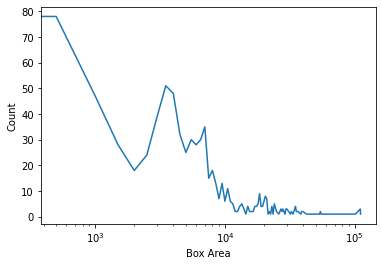

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
  person_area_pdf["box_area"], 
  person_area_pdf["cnt"]
)
plt.xscale("log")
plt.xlabel("Box Area")
plt.ylabel("Count")

This time, it is not surprise. Smaller (between $10^2$ and $10^4$ pixels) objects have less pixels, thus less features to can be computed in a CNN.


# Data Mining and Pre-Labelling

Its pendamic (2022), everyone works from home. Our field team could not have enough resources to collecting all the data we need.

Can we mine high-value data from all the petabytes of data sitting in our datalake to improve our model performance *NOW*?

Lets find some new data for label, which satisify:
 * Is `chair`, `remote` or `phone`
 * Box area is between $10^2$ to $10^4$ pixels
 * Has low confidence (`score < 0.7`)

In [ ]:
spark.sql("""
SELECT image_id, image, detection.* FROM (
    SELECT image_id, image, explode(ML_PREDICT(ssd, image)) as detection FROM coco_1k
) WHERE 
    100 < area(detection.box) AND area(detection.box) < 10000 
    AND coco_name(detection.label_id) IN ('chair', 'remote', 'phone')
    AND detection.score < 0.7
""").show()

22/01/29 01:19:56 WARN TaskSetManager: Stage 118 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.
/home/lei/miniconda3/envs/coco/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/lei/miniconda3/envs/coco/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The obtained data can then be sent to the labeling or QA teams, with ***pre-labelled*** annotations. 
These pre-labeling techniques have been demostrated significant efficiency improvements in practice.

# Close the loop

As our examples have shown, even with a well-established public dataset (COCO) and a popular model (SSD, https://arxiv.org/abs/1512.02325), there are still plenty of interesting edge-cases and insights to be discovered. For real-world datasets in production AI where data quality tends to be much worse, active learning is an even more important tool to improve the quality of your models.

